In [1]:
import pandas as pd

import numpy as np
import sys, os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib

import statsmodels.api as sm
import statsmodels.stats.multitest as statsmulti

matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2.5
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [2]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.gexat_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

## Modelling impact of splicing on reporter expression

In [3]:
# import splicing measurement
HELA = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')

# assume each reporter is spliced with only one primary isoform 
isoforms = HELA[HELA['best_category']!='full_length']
isoforms = isoforms.loc[isoforms.groupby('RE')['fraction'].idxmax()] # primary isoform = isoform with highest fraction
isoforms = isoforms[['RE', 'best_category']].rename(columns = {'best_category': 'isoform'})

# calculate spliced fraction (= 1 - full length fraction) and assign to primary isoform
HELA['spliced_fraction'] = 1 - HELA['fraction']
HELA['FL_fraction'] = HELA['fraction']
HELA = HELA[HELA['best_category']=='full_length']
HELA = HELA.merge(isoforms, on = 'RE', how = 'outer')
HELA = HELA[['RE', 'isoform', 'fraction', 'FL_fraction', 'spliced_fraction']] # simplify dataframe

In [4]:
acceptor_pos_dict = {0: (157, 190), 
                     1: (190, 223), 
                     2: (223, 257), 
                     3: (257, 290)}

# function to retrieve isoform name
def splice_isoform(RE, isoform, spliced_fraction):
    if spliced_fraction <= 0.10 or 'A' not in RE: # reporter less than 1% spliced is considered not spliced
        return 'not_spliced'
    
    _, donor_pos, _, acceptor_pos = isoform.split('_')

    if donor_pos == '132':
        donor = 'GFP'
    elif donor_pos == '171' or donor_pos == '204':
        donor = 'PRE'
    else:
        donor = 'other'

    if acceptor_pos == '319':
        acceptor = 'Spacer'
    else:
        found = False
        acceptor = ''
        for acc, pos in acceptor_pos_dict.items():
            if pos[0] <= int(acceptor_pos) < pos[1]:
                found = True
                acceptor = RE[acc] + str(acc+1)


        if not found:
            acceptor = 'other'
            acceptor_extended = 'other'

    return donor + '_' + acceptor
    
HELA['isoform']= HELA.apply(lambda g: splice_isoform(g['RE'], g['isoform'], g['spliced_fraction']),axis = 1)

In [5]:
# Import expresion data from original PTRE-seq publication (Cotrell et al 2018)
# Relative RNA expression is calculated as previously described

# RNA expression data
RNA = pd.read_excel('data/sup3_readscount_HeLa_total.xlsx')
RNA = RNA[RNA['counts_RNA']>10] # exclude measurements with less than 10 counts

# plasmid expression data
plasmid = pd.read_excel('data/sup2_readscount_plasmid.xlsx')
# read barcode
bc = pd.read_csv('data/barcode_indexed.txt', sep = '\t', names = ['plasmid', 'Barcode'])
avg_plasmid = plasmid.groupby(['Barcode'])['counts_Plasmid'].mean().reset_index()
# merge
ptreseq = RNA.merge(avg_plasmid, on = ['Barcode'], suffixes = ['_RNA', '_DNA'])
ptreseq = ptreseq.merge(bc, on = 'Barcode')

# rename some plasmids
rename_dict = {'Lpcx1': '7pcx1', 'Lpcx2': '7pcx2', 'Lpcx4': '7pcx4'}

def rename_f(p):
    if p in rename_dict.keys():
        return rename_dict[p]
    else:
        return p
    
ptreseq['RE'] = ptreseq['RE_Identity'].apply(lambda g: rename_f(g))

# normalize raw count by plasmid count
ptreseq['RNA/DNA'] = ptreseq['counts_RNA']/ptreseq['counts_Plasmid']

# Calculate BBBB median and normalize expression
BBBB = ptreseq[ptreseq['RE_Identity']=='BBBB']
median_exp = BBBB['RNA/DNA'].median()

# normalized by median of BBBB normalized count
ptreseq['normEXP'] = ptreseq['RNA/DNA']/median_exp
ptreseq['L2FC'] = np.log2(ptreseq['normEXP'])

# get the median between 4 replicates and barcodes
ptreseq = ptreseq.groupby(['RE_Identity'])[['counts_RNA', 
                                'counts_Plasmid', 
                                'RNA/DNA', 
                                'normEXP', 
                                'L2FC']].median().reset_index()

# change column name
ptreseq.columns = ['RE', 'counts_RNA', 'counts_Plasmid', 'RNA/DNA', 'normEXP', 'L2FC']

In [6]:
df_for_model = ptreseq.merge(HELA, on = 'RE') # merge expression data with splicing data
df_for_model = df_for_model[df_for_model['RE'].str.contains('^[BLpSA]{4}$')].reset_index(drop = True)

# get identity for RE at each position
df_for_model['P1'] = df_for_model['RE'].apply(lambda g: g[0])
df_for_model['P2'] = df_for_model['RE'].apply(lambda g: g[1])
df_for_model['P3'] = df_for_model['RE'].apply(lambda g: g[2])
df_for_model['P4'] = df_for_model['RE'].apply(lambda g: g[3])

# correlation between splicing efficiency and reporter expression
print(df_for_model[['spliced_fraction', 'L2FC']].corr())

                  spliced_fraction      L2FC
spliced_fraction          1.000000  0.739776
L2FC                      0.739776  1.000000


## Linear regression model

In [7]:
# formula considers RE identity, position, and interaction
formula = "L2FC ~ C(P1, Treatment(reference='B'))*C(P2, Treatment(reference='B')) \
                + C(P1, Treatment(reference='B'))*C(P3, Treatment(reference='B')) \
                + C(P1, Treatment(reference='B'))*C(P4, Treatment(reference='B')) \
                + C(P2, Treatment(reference='B'))*C(P3, Treatment(reference='B')) \
                + C(P2, Treatment(reference='B'))*C(P4, Treatment(reference='B')) \
                + C(P3, Treatment(reference='B'))*C(P4, Treatment(reference='B'))"


# limit to only reporters < 1% spliced
df_for_model_nosplice = df_for_model[df_for_model['isoform']=='not_spliced']

# linear regression model
model_nosplice = sm.formula.glm(formula = formula, 
                                data = df_for_model_nosplice, 
                                family=sm.families.Gaussian()).fit()

# Assess fit of model
temp = df_for_model_nosplice[['RE', 'L2FC']].reset_index(drop = True)
temp['ypred'] = model_nosplice.predict() # predict expression of only unspliced reporters
print(temp.corr())

           L2FC     ypred
L2FC   1.000000  0.970203
ypred  0.970203  1.000000


### Estimate expression of full length isoforms

In [8]:
df_for_estimate = df_for_model.copy()

# use result of reporters trained on unspliced reporters to predict full-length expression of spliced reporters
df_for_estimate['L2FC_FL_exp'] = model_nosplice.predict(exog = df_for_estimate)
df_for_estimate['FL_exp'] = 2**df_for_estimate['L2FC_FL_exp'] # convert l2fc back to normalized exp

### Estimate expression of spliced isoforms (GFP_B4 and GFP_p4)

In [9]:
# Calculate variables for Equation 2 (Method)
    # normEXP = Etot
    # spliced fraction = s
    # 1/FL_exp = Bf/a0
    
df_for_estimate['X'] = df_for_estimate['normEXP']*df_for_estimate['spliced_fraction']
df_for_estimate['Y'] = df_for_estimate['normEXP']*(1 - df_for_estimate['spliced_fraction'])*(1/df_for_estimate['FL_exp'])
df_for_estimate['stability_full'] = 1/df_for_estimate['FL_exp']

estimated_isoform_stability = {}
estimated_isoform_expression = {}
isoform_df = {}

# tested 0.10-0.70, 0.10-0.80, 0.10-0.90
# to generate Fig S1E and S1F, change the upper limit to 0.70 and 0.90 respectively 
lower_limit = 0.10
upper_limit = 0.80

for isoform in ['GFP_B4', 'GFP_p4']:
    print(isoform)
    subgroup_model = df_for_estimate[df_for_estimate['isoform']==isoform]
    
    #exclude certain splicing percentage
    subgroup_model = subgroup_model[
        (lower_limit<=subgroup_model['spliced_fraction'])&(subgroup_model['spliced_fraction']<=upper_limit)
    ]
    isoform_df[isoform] = subgroup_model

    # model, where X = expression of spliced isoform
    formula = "Y ~ X"
    model = sm.formula.glm(formula = formula, data = subgroup_model, family=sm.families.Gaussian()).fit()

    estimated_isoform_stability[isoform] = -model.params['X']
    estimated_isoform_expression[isoform] = -1/model.params['X']
    isoform_df[isoform]['spliced_fraction_exp'] = -model.params['X']
    
    print(f'Stability of {isoform} is {-model.params["X"]}, {len(subgroup_model)} reporters')
    print(f'Expression of {isoform} is {-1/model.params["X"]}, {len(subgroup_model)} reporters')

GFP_B4
Stability of GFP_B4 is 0.562193440117971, 11 reporters
Expression of GFP_B4 is 1.778747186715945, 11 reporters
GFP_p4
Stability of GFP_p4 is 0.9059832690765439, 12 reporters
Expression of GFP_p4 is 1.103773142543003, 12 reporters


### Calculate reporter expression assuming RE-excision model and estimate transcription fold change

In [10]:
def estimate_L2FC_transcriptionFC(normEXP, S_fraction, FL_fraction, FL_exp, isoform):
    if isoform == 'GFP_B4' or isoform == 'GFP_p4':
        spliced_stability = estimated_isoform_stability[isoform] # = beta-f/alpha-0
        estimated_total_exp = 1/(S_fraction*spliced_stability + FL_fraction/FL_exp) # assume alpha-total/alpha-0 = 1
        transcription_FL = normEXP*(S_fraction*spliced_stability + FL_fraction/FL_exp)
        
        return np.log2(estimated_total_exp), transcription_FL
    else:
        return np.nan, np.nan

df_for_estimate['estimated_L2FC_RE_excision'], df_for_estimate['a/a0'] = zip(
                                                                        *df_for_estimate.apply(
                                                                        lambda g: estimate_L2FC_transcriptionFC(
                                                                            g['normEXP'],
                                                                            g['spliced_fraction'],
                                                                            g['FL_fraction'],
                                                                            g['FL_exp'],
                                                                            g['isoform']
                                                                        ),
                                                                        axis = 1)
                                                                        )

## Figure 4A: RE-excision mechanism

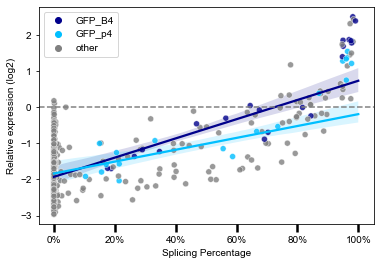

In [11]:
f, ax = plt.subplots()

df_for_estimate['hue'] = df_for_estimate['isoform'].apply(
    lambda g: g if g in ['GFP_B4', 'GFP_p4'] else 'other')

# Plot GFP_B4 isoform
GFP_B4 = df_for_estimate[df_for_estimate['hue']=='GFP_B4']
GFP_B4 = GFP_B4[(GFP_B4['spliced_fraction']>0.1)&(GFP_B4['spliced_fraction']<0.9)]

sns.regplot(
    data = GFP_B4, 
    x = 'spliced_fraction', 
    y = 'estimated_L2FC_RE_excision',
    scatter = False,
    color = 'darkblue',
    truncate = False,
    ax = ax
)

# Plot GFP_p4 isoform
GFP_p4 = df_for_estimate[df_for_estimate['hue']=='GFP_p4']
GFP_p4 = GFP_p4[(GFP_p4['spliced_fraction']>0.1)&(GFP_p4['spliced_fraction']<0.9)]

sns.regplot(
    data = GFP_p4, 
    x = 'spliced_fraction', 
    y = 'estimated_L2FC_RE_excision',
    scatter = False,
    color = 'deepskyblue',
    truncate = False,
    ax = ax
)

# Scatterplot of splicing efficiency and relative expression
sns.scatterplot(data = df_for_estimate, 
                x = 'spliced_fraction', 
                y = 'L2FC', 
                hue = 'hue',
                hue_order = ['GFP_B4', 'GFP_p4', 'other'],
                palette = ['darkblue', 'deepskyblue', 'grey'],
                alpha = 0.8,
                ax = ax
               )


ax.set_xlabel('Splicing Percentage')
ax.set_ylabel('Relative expression (log2)')

ax.set_xlim(-0.05, 1.05)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.legend(title = '')

ax.axhline(0, color = 'grey', linestyle = '--')

#f.savefig(f'PLOTS/Fig_4A_RE_excision_model_{lower_limit}_{upper_limit}_cutoff.pdf', transparent = True)

## Figure 4C: scatterplot of transcription fold change

(0.25, 4.0)

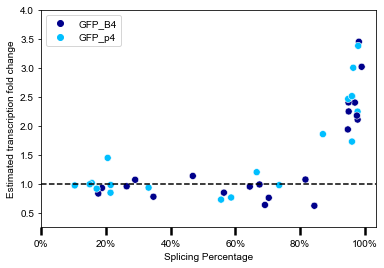

In [12]:
# Plot fold change transcription vs splicing fraction

f, ax = plt.subplots(figsize = (6, 4))

sns.scatterplot(
    data = df_for_estimate, 
    x = 'spliced_fraction', 
    y = 'a/a0', 
    hue = 'isoform',
    hue_order = ['GFP_B4', 'GFP_p4'],
    palette = ['darkblue', 'deepskyblue'],
    s = 50,
    ax = ax)

ax.axhline(1, linestyle = '--', color = 'black')

ax.set_xlabel('Splicing Percentage')
ax.set_ylabel('Estimated transcription fold change')

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.legend(title = '')

ax.set_ylim(0.25, 4)

#f.savefig(f'PLOTS/Fig_4C_transcription_fold_change_{lower_limit}_{upper_limit}.pdf', transparent = True)

## Figure S5B and S5C: linear regression to estimate spliced isoforms stability

<AxesSubplot:xlabel='X', ylabel='Y'>

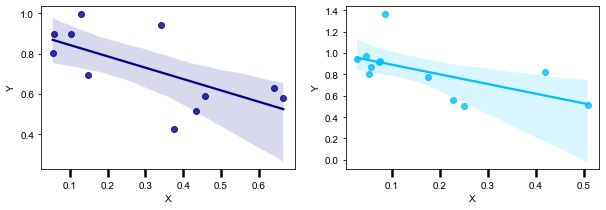

In [13]:
f, axs = plt.subplots(ncols = 2, figsize = (10, 3))

sns.regplot(data = isoform_df['GFP_B4'], 
            x = 'X', y = 'Y', color = 'darkblue', ax = axs[0])

sns.regplot(data = isoform_df['GFP_p4'], 
            x = 'X', y = 'Y', color = 'deepskyblue', ax = axs[1])


#f.savefig('PLOTS/Fig_S4B.pdf', transparent = True)

## Figure S5D: histogram of full-length stability

(-3.1, 1.0)

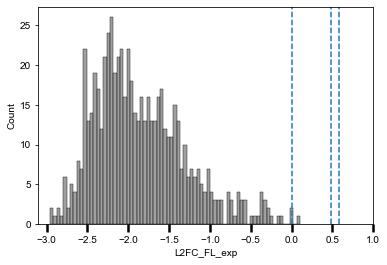

In [14]:
f, ax = plt.subplots()

sns.histplot(data = df_for_estimate, x = 'L2FC_FL_exp', color = 'grey', bins = 75, ax = ax)

ax.axvline(np.log2(1), linestyle = '--') # expression "blank" control
ax.axvline(np.log2(1.5), linestyle = '--') # estimated expression of GFP_P4 isoform
ax.axvline(np.log2(1.4), linestyle = '--') # estimated expression of GFP_B4 isoform

ax.set_xlim(-3.1, 1.0)

#f.savefig('PLOTS/Figure_S4D_distribution.pdf')

## Model using data from "no spacer" library

In [15]:
# import splicing measurement
nospacer = pd.read_csv('ptreseq_splicing_quantification/HELA-nospacer_1rep_fraction.txt', sep = '\t')

# exclude RE with multiple isoforms
RE_to_exclude = []
for RE in nospacer['RE'].unique():
    temp = nospacer[nospacer['RE']==RE]
    temp = temp[temp['fraction']>0.05]
    if len(temp) > 2:
        RE_to_exclude.append(RE)

# assume each reporter is spliced with only one primary isoform 
isoforms = nospacer[nospacer['best_category']!='full_length']
isoforms = isoforms.loc[isoforms.groupby('RE')['fraction'].idxmax()]# primary isoform = isoform with highest fraction
isoforms = isoforms[['RE', 'best_category']].rename(columns = {'best_category': 'isoform'})

# calculate spliced fraction (= 1 - full length fraction) and assign to primary isoform
nospacer['spliced_fraction'] = 1 - nospacer['fraction']
nospacer['FL_fraction'] = nospacer['fraction']
nospacer = nospacer[nospacer['best_category']=='full_length']
nospacer = nospacer.merge(isoforms, on = 'RE', how = 'outer')
nospacer = nospacer[['RE', 'isoform', 'fraction', 'FL_fraction', 'spliced_fraction']] # simplify dataframe

acceptor_pos_dict = {0: (157, 190), 
                     1: (190, 223), 
                     2: (223, 257), 
                     3: (257, 290)}

# function to retrieve isoform name
def splice_isoform(RE, isoform, spliced_fraction):
    if spliced_fraction <= 0.10 or 'A' not in RE or isoform is np.nan: # reporter less than 1% spliced is considered not spliced
        return 'not_spliced'

    _, donor_pos, _, acceptor_pos = isoform.split('_')

    if donor_pos == '132':
        donor = 'GFP'
    elif donor_pos == '171' or donor_pos == '204':
        donor = 'PRE'
    else:
        donor = 'other'

    if acceptor_pos == '319':
        acceptor = 'Spacer'
    else:
        found = False
        acceptor = ''
        for acc, pos in acceptor_pos_dict.items():
            if pos[0] <= int(acceptor_pos) < pos[1]:
                found = True
                acceptor = RE[acc] + str(acc+1)


        if not found:
            acceptor = 'other'
            acceptor_extended = 'other'

    return donor + '_' + acceptor
    
nospacer['isoform']= nospacer.apply(lambda g: splice_isoform(g['RE'], g['isoform'], g['spliced_fraction']),axis = 1)

In [16]:
# calculate relative RNA expression using measurements from "no spacer" library
def calculate_CPM(fn, drop):
    df = pd.read_csv(fn, sep = '\t')
    df = df[df['reporter']!='-1']
    
    if drop:
        df = df[df['best_category']!='PCR_chimera'].reset_index()
    
    # filter out barcodes with less than 10 reads
    total_count = df.groupby('reporter')['count'].sum()
    reporter_less_than_10 = total_count[total_count<=10].index
    filtered_df = df[~df['reporter'].isin(reporter_less_than_10)].reset_index(drop = True)
    
    df = filtered_df.groupby('reporter').sum(numeric_only = True).reset_index()
    df['count'] = df['count']*1000000/df['count'].sum()
    df['RE'] = df['reporter'].apply(lambda g: g.split('_')[0])
    return df

# read input RNA count measured using extended primers
hela_nospacer = calculate_CPM('ptreseq_raw_count/HELA-nospacer_raw_count.txt', False)

# read input DNA count measured using extended primers
dna_nospacer = calculate_CPM('ptreseq_raw_count/DNA-nospacer_raw_count.txt', False)
dna_nospacer_avg = dna_nospacer.groupby('RE').median().reset_index()

# normalize RNA count by DNA count
nospacer_count = hela_nospacer[
    ['reporter', 'RE', 'count']
].merge(
    dna_nospacer_avg[['RE', 'count']], 
    on = 'RE', suffixes = ('_RNA', '_DNA')
)

nospacer_count['RNA/DNA'] = nospacer_count['count_RNA']/nospacer_count['count_DNA']
#nospacer_count['RNA/DNA'] = nospacer_count['CPM_RNA']

# Calculate BBBB median and normalize expression
BBBB = nospacer_count[nospacer_count['RE']=='BBBB']
median_exp = BBBB['RNA/DNA'].median()
# normalized by median of BBBB normalized count
nospacer_count['normEXP'] = nospacer_count['RNA/DNA']/median_exp
nospacer_count['L2FC'] = np.log2(nospacer_count['RNA/DNA']/median_exp)

# get the median between 4 replicates and barcodes
nospacer_count_med = nospacer_count.groupby(['RE'])[['count_RNA', 
                                'count_DNA', 
                                'RNA/DNA', 
                                'normEXP', 
                                'L2FC']].median().reset_index()

# change column name
nospacer_count_med.columns = ['RE', 'counts_RNA', 'counts_Plasmid', 'RNA/DNA', 'normEXP', 'L2FC']

In [17]:
df_for_model_nospacer = nospacer_count_med.merge(nospacer, on = 'RE') # merge expression data with splicing data
#df_for_model_nospacer = df_for_model_nospacer[~df_for_model_nospacer['RE'].isin(RE_to_exclude)]
df_for_model_nospacer = df_for_model_nospacer[df_for_model_nospacer['RE'].str.contains('^[BLpSA]{4}$')].reset_index(drop = True)

# get identity for RE at each position
df_for_model_nospacer['P1'] = df_for_model_nospacer['RE'].apply(lambda g: g[0])
df_for_model_nospacer['P2'] = df_for_model_nospacer['RE'].apply(lambda g: g[1])
df_for_model_nospacer['P3'] = df_for_model_nospacer['RE'].apply(lambda g: g[2])
df_for_model_nospacer['P4'] = df_for_model_nospacer['RE'].apply(lambda g: g[3])

# correlation between splicing efficiency and reporter expression
#print(df_for_model_nospacer[['spliced_fraction', 'L2FC']].corr())

# limit to only reporters < 1% spliced
df_for_model_nospacer_nosplice = df_for_model_nospacer[df_for_model_nospacer['isoform']=='not_spliced']

# formula considers RE identity, position, and interaction
formula = "L2FC ~ C(P1, Treatment(reference='B'))*C(P2, Treatment(reference='B')) \
                + C(P1, Treatment(reference='B'))*C(P3, Treatment(reference='B')) \
                + C(P1, Treatment(reference='B'))*C(P4, Treatment(reference='B')) \
                + C(P2, Treatment(reference='B'))*C(P3, Treatment(reference='B')) \
                + C(P2, Treatment(reference='B'))*C(P4, Treatment(reference='B')) \
                + C(P3, Treatment(reference='B'))*C(P4, Treatment(reference='B'))"

# linear regression model
model_nosplice_nospacer = sm.formula.glm(formula = formula, 
                                data = df_for_model_nospacer_nosplice, 
                                family=sm.families.Gaussian()).fit()


# make a copy
df_for_estimate_nospacer = df_for_model_nospacer.copy()

# use result of reporters trained on unspliced reporters to predict full-length expression of spliced reporters
df_for_estimate_nospacer['L2FC_FL_exp'] = model_nosplice_nospacer.predict(exog = df_for_estimate_nospacer)
df_for_estimate_nospacer['FL_exp'] = 2**df_for_estimate_nospacer['L2FC_FL_exp'] # convert l2fc back to normalized exp

In [18]:
# Calculate variables for Equation 2 (Method)
    # normEXP = Etot
    # spliced fraction = s
    # 1/FL_exp = Bf/a0
    
df_for_estimate_nospacer['X'] = df_for_estimate_nospacer['normEXP']*df_for_estimate_nospacer['spliced_fraction']
df_for_estimate_nospacer['Y'] = df_for_estimate_nospacer['normEXP']*(1 - df_for_estimate_nospacer['spliced_fraction'])*(1/df_for_estimate_nospacer['FL_exp'])
df_for_estimate_nospacer['stability_full'] = 1/df_for_estimate_nospacer['FL_exp']

estimated_isoform_stability = {}
estimated_isoform_expression = {}
isoform_df = {}

# tested 0.10-0.70, 0.10-0.80, 0.10-0.90
# to generate Fig S1E and S1F, change the upper limit to 0.70 and 0.90 respectively 
#lower_limit = 0.01
#upper_limit = 0.60

isoform_ls = {
    'GFP_B4': (0.10, 0.80),
    'GFP_p4': (0.10, 0.80),
}

for isoform, lim in isoform_ls.items():
    subgroup_model = df_for_estimate_nospacer[df_for_estimate_nospacer['isoform']==isoform]
    #subgroup_model = df_for_estimate_nospacer[df_for_estimate_nospacer['isoform'].isin(['GFP_p4'])]
    #print(subgroup_model[['RE','L2FC', 'spliced_fraction', 'X', 'Y']].sort_values(by='spliced_fraction'))
    
    #exclude certain splicing percentage
    lower_limit = lim[0]
    upper_limit = lim[1]
    
    subgroup_model = subgroup_model[
        (lower_limit<=subgroup_model['spliced_fraction'])&(subgroup_model['spliced_fraction']<=upper_limit)
    ]
    isoform_df[isoform] = subgroup_model

    # model, where X = expression of spliced isoform
    formula = "Y ~ X"
    model = sm.formula.glm(formula = formula, data = subgroup_model, family=sm.families.Gaussian()).fit()

    estimated_isoform_stability[isoform] = -model.params['X']
    estimated_isoform_expression[isoform] = -1/model.params['X']
    isoform_df[isoform]['spliced_fraction_exp'] = -model.params['X']
    
    #estimated_isoform_stability[isoform] = model.params['X']
    #estimated_isoform_expression[isoform] = 1/model.params['X']
    #isoform_df[isoform]['spliced_fraction_exp'] = model.params['X']
    
    print(f'Stability of {isoform} is {model.params["X"]}, {len(subgroup_model)} reporters, {lower_limit}, {upper_limit}')
    print(f'Expression of {isoform} is {1/model.params["X"]}, {len(subgroup_model)} reporters')

Stability of GFP_B4 is -2.766116779781462, 8 reporters, 0.1, 0.8
Expression of GFP_B4 is -0.361517636315776, 8 reporters
Stability of GFP_p4 is -0.3431692877677315, 6 reporters, 0.1, 0.8
Expression of GFP_p4 is -2.9140136825904817, 6 reporters


In [19]:
def estimate_L2FC_transcriptionFC(normEXP, S_fraction, FL_fraction, FL_exp, isoform):
    if isoform in isoform_ls.keys():
        spliced_stability = estimated_isoform_stability[isoform] # = beta-f/alpha-0
        estimated_total_exp = 1/(S_fraction*spliced_stability + FL_fraction/FL_exp) # assume alpha-total/alpha-0 = 1
        transcription_FL = normEXP*(S_fraction*spliced_stability + FL_fraction/FL_exp)
        
        return np.log2(estimated_total_exp), transcription_FL
    else:
        return np.nan, np.nan

df_for_estimate_nospacer['estimated_L2FC_RE_excision'], df_for_estimate_nospacer['a/a0'] = zip(
                                                                        *df_for_estimate_nospacer.apply(
                                                                        lambda g: estimate_L2FC_transcriptionFC(
                                                                            g['normEXP'],
                                                                            g['spliced_fraction'],
                                                                            g['FL_fraction'],
                                                                            g['FL_exp'],
                                                                            g['isoform']
                                                                        ),
                                                                        axis = 1)
                                                                        )

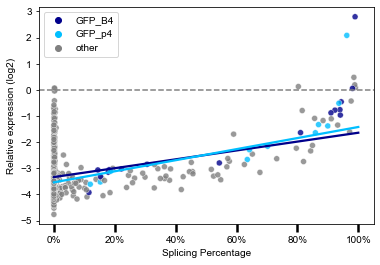

In [20]:
f, ax = plt.subplots()

df_for_estimate_nospacer['hue'] = df_for_estimate_nospacer['isoform'].apply(
    lambda g: g if g in isoform_ls.keys() else 'other')

# Plot GFP_B4 isoform
GFP_B4 = df_for_estimate_nospacer[df_for_estimate_nospacer['hue']=='GFP_B4']
GFP_B4 = GFP_B4[(GFP_B4['spliced_fraction']>isoform_ls['GFP_B4'][0])&(GFP_B4['spliced_fraction']<isoform_ls['GFP_B4'][1])]

sns.regplot(
    data = GFP_B4, 
    x = 'spliced_fraction', 
    y = 'estimated_L2FC_RE_excision',
    scatter = False,
    color = 'darkblue',
    truncate = False,
    ci = False,
    ax = ax
)

# Plot GFP_p4 isoform
GFP_p4 = df_for_estimate_nospacer[df_for_estimate_nospacer['hue']=='GFP_p4']
GFP_p4 = GFP_p4[(GFP_p4['spliced_fraction']>isoform_ls['GFP_p4'][0])&(GFP_p4['spliced_fraction']<isoform_ls['GFP_p4'][1])]

sns.regplot(
    data = GFP_p4, 
    x = 'spliced_fraction', 
    y = 'estimated_L2FC_RE_excision',
    scatter = False,
    color = 'deepskyblue',
    truncate = False,
    ci = False,
    ax = ax
)

# Scatterplot of splicing efficiency and relative expression
sns.scatterplot(data = df_for_estimate_nospacer, 
                x = 'spliced_fraction', 
                y = 'L2FC', 
                hue = 'hue',
                hue_order = list(isoform_ls.keys()) + ['other'],
                palette = ['darkblue', 'deepskyblue', 'grey'],
                alpha = 0.8,
                ax = ax
               )



ax.set_xlabel('Splicing Percentage')
ax.set_ylabel('Relative expression (log2)')

ax.set_xlim(-0.05, 1.05)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.legend(title = '', loc = 'upper left')

ax.axhline(0, color = 'grey', linestyle = '--')

#f.savefig(f'PLOTS/Fig_RE_excision_model_NOSPACER.pdf', transparent = True)

(0.0, 4.0)

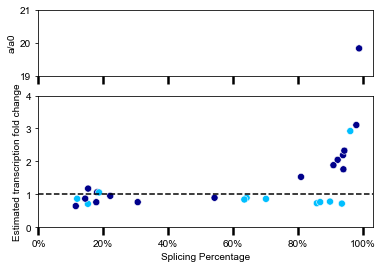

In [21]:
# Plot fold change transcription vs splicing fraction

f, axs = plt.subplots(figsize = (6, 4), sharex = True, nrows = 2, 
                     gridspec_kw={'height_ratios': (1, 2)})

for ax in axs:
    sns.scatterplot(
        data = df_for_estimate_nospacer, 
        x = 'spliced_fraction', 
        y = 'a/a0', 
        hue = 'isoform',
        hue_order = isoform_ls.keys(),
        palette = ['darkblue', 'deepskyblue'],
        s = 50,
        ax = ax)
    
    ax.get_legend().remove()

axs[1].axhline(1, linestyle = '--', color = 'black')

axs[1].set_xlabel('Splicing Percentage')
axs[1].set_ylabel('Estimated transcription fold change')

axs[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[1].set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

axs[0].set_ylim(19, 21)
axs[1].set_ylim(0, 4)

#ax.legend(loc = 'upper left')

#f.savefig(f'PLOTS/Fig_4C_transcription_fold_change_NOSPACER.pdf', transparent = True)